In [67]:
import requests
import re
import numpy as np
import json
import pandas as pd

In [68]:
corp = []

In [69]:
with open("gyakori_szamitastechnika_line", "r+") as f:
    for i,line in enumerate(f):
        obj = json.loads(line.strip("\n"))
        corp.append(obj)

In [70]:
df = pd.DataFrame(corp)

In [71]:
df["kategoriak"] = df.kategoriak.apply(lambda x: x[1])

In [72]:
df.kategoriak

0           Internet
1        Programozás
2        Programozás
3          Hardverek
4          Hardverek
            ...     
23449      Hardverek
23450      Hardverek
23451    Programozás
23452    Programozás
23453      Hardverek
Name: kategoriak, Length: 23454, dtype: object

In [73]:
p = df.groupby("kategoriak").size()

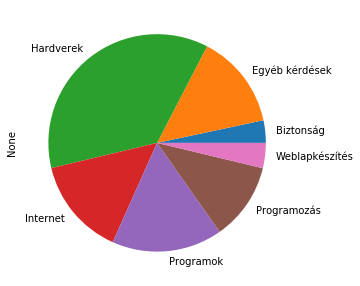

In [74]:
p.plot.pie(figsize=(5, 5))

In [75]:
df.hosszu_kerdes.str.len()

0        156
1        310
2        118
3        659
4         58
        ... 
23449    569
23450    103
23451    606
23452    335
23453     88
Name: hosszu_kerdes, Length: 23454, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split as split

In [111]:
type(df.hosszu_kerdes)

In [84]:
import hu_core_ud_lg
import tqdm

In [134]:
from tqdm import tqdm
from gensim.models.keyedvectors import KeyedVectors

In [83]:
hu_nlp = hu_core_ud_lg.load()

In [126]:
def preprocess_text(data):
    print(len(data))
    clean_data = []
    for i,kerdes in tqdm(enumerate(data), "Preprocessing"):
        doc = hu_nlp(data[i])
        clean_data.append([tok.lemma_ for tok in doc if tok.is_alpha and not tok.is_stop])
    return clean_data

In [151]:
def vectorize(tr_data, tst_data):
    print('\nLoading existing FastText model...')
    model = KeyedVectors.load_word2vec_format("./embeddings/hu.szte.w2v.fasttext.vec.2")
    vectorizer = model.wv
    vocab_length = len(model.wv.vocab)
    tr_vectors = [
        np.array([vectorizer[word] for word in tweet if word in model]).flatten() for tweet in tqdm(tr_data,'Vectorizing')
        ]
    max_len = np.max([len(vector) for vector in tr_vectors])
    tr_vectors = [
        np.array(vector.tolist()+[0 for _ in range(max_len-len(vector))]) for vector in tqdm(tr_vectors,'Finalizing')
        ]
    
    tst_vectors = [
        np.array([vectorizer[word] for word in tweet if word in model]).flatten() for tweet in tqdm(tst_data,'Vectorizing')
        ]

    tst_vectors = [
        np.array(vector.tolist()+[0 for _ in range(max_len-len(vector))]) for vector in tqdm(tst_vectors,'Finalizing')
        ]
    
    return tr_vectors, tst_vectors

In [152]:
def get_features_and_labels(data, labels):
    tr_data,tst_data,tr_labels,tst_labels = split(data,labels,test_size=0.3)
    tr_data_clean = preprocess_text(tr_data)
    tst_data_clean = preprocess_text(tst_data)
    
    tst_vecs = []
    tr_vecs = []
    tr_vecs, tst_vecs = vectorize(tr_data_clean, tst_data_clean)    
    return tr_vecs, tr_labels, tst_vecs, tst_labels

In [153]:
tr_vecs, tr_labels, tst_vecs, tst_labels = get_features_and_labels(df.hosszu_kerdes.tolist(), df.kategoriak.tolist())


Preprocessing: 0it [00:00, ?it/s]

16417



Preprocessing: 1it [00:00,  1.48it/s]
Preprocessing: 4it [00:00,  2.06it/s]
Preprocessing: 6it [00:00,  2.79it/s]
Preprocessing: 9it [00:01,  3.77it/s]
Preprocessing: 13it [00:01,  5.17it/s]
Preprocessing: 17it [00:01,  6.89it/s]
Preprocessing: 22it [00:01,  9.23it/s]
Preprocessing: 29it [00:01, 12.47it/s]
Preprocessing: 36it [00:01, 16.46it/s]
Preprocessing: 42it [00:01, 20.80it/s]
Preprocessing: 49it [00:01, 26.09it/s]
Preprocessing: 57it [00:01, 32.04it/s]
Preprocessing: 64it [00:02, 38.10it/s]
Preprocessing: 71it [00:02, 43.84it/s]
Preprocessing: 79it [00:02, 50.06it/s]
Preprocessing: 86it [00:02, 52.66it/s]
Preprocessing: 93it [00:02, 48.81it/s]
Preprocessing: 99it [00:02, 51.08it/s]
Preprocessing: 107it [00:02, 56.33it/s]
Preprocessing: 114it [00:02, 58.53it/s]
Preprocessing: 121it [00:03, 51.11it/s]
Preprocessing: 129it [00:03, 56.99it/s]
Preprocessing: 139it [00:03, 65.33it/s]
Preprocessing: 147it [00:03, 67.39it/s]
Preprocessing: 156it [00:03, 71.74it/s]
Preprocessing: 164it 

Preprocessing: 1619it [00:23, 85.23it/s]
Preprocessing: 1628it [00:23, 83.38it/s]
Preprocessing: 1638it [00:23, 85.79it/s]
Preprocessing: 1648it [00:23, 88.23it/s]
Preprocessing: 1657it [00:23, 80.62it/s]
Preprocessing: 1668it [00:23, 85.92it/s]
Preprocessing: 1677it [00:23, 81.61it/s]
Preprocessing: 1686it [00:23, 81.03it/s]
Preprocessing: 1695it [00:24, 78.58it/s]
Preprocessing: 1705it [00:24, 82.36it/s]
Preprocessing: 1714it [00:24, 78.99it/s]
Preprocessing: 1725it [00:24, 82.67it/s]
Preprocessing: 1734it [00:24, 83.28it/s]
Preprocessing: 1743it [00:24, 80.24it/s]
Preprocessing: 1753it [00:24, 85.03it/s]
Preprocessing: 1762it [00:24, 83.18it/s]
Preprocessing: 1773it [00:24, 88.15it/s]
Preprocessing: 1783it [00:25, 87.90it/s]
Preprocessing: 1793it [00:25, 89.75it/s]
Preprocessing: 1803it [00:25, 89.98it/s]
Preprocessing: 1813it [00:25, 92.34it/s]
Preprocessing: 1823it [00:25, 89.51it/s]
Preprocessing: 1833it [00:25, 92.15it/s]
Preprocessing: 1843it [00:25, 93.55it/s]
Preprocessing: 1

Preprocessing: 3309it [00:44, 78.59it/s]
Preprocessing: 3318it [00:44, 79.52it/s]
Preprocessing: 3327it [00:44, 81.85it/s]
Preprocessing: 3336it [00:44, 82.61it/s]
Preprocessing: 3346it [00:44, 86.26it/s]
Preprocessing: 3355it [00:45, 82.43it/s]
Preprocessing: 3364it [00:45, 78.35it/s]
Preprocessing: 3373it [00:45, 80.07it/s]
Preprocessing: 3382it [00:45, 81.56it/s]
Preprocessing: 3391it [00:45, 83.15it/s]
Preprocessing: 3400it [00:45, 83.68it/s]
Preprocessing: 3409it [00:45, 76.10it/s]
Preprocessing: 3417it [00:45, 72.48it/s]
Preprocessing: 3425it [00:46, 70.97it/s]
Preprocessing: 3433it [00:46, 73.35it/s]
Preprocessing: 3445it [00:46, 80.82it/s]
Preprocessing: 3456it [00:46, 85.77it/s]
Preprocessing: 3465it [00:46, 84.20it/s]
Preprocessing: 3475it [00:46, 87.68it/s]
Preprocessing: 3484it [00:46, 82.71it/s]
Preprocessing: 3494it [00:46, 86.34it/s]
Preprocessing: 3504it [00:46, 88.53it/s]
Preprocessing: 3514it [00:46, 86.97it/s]
Preprocessing: 3523it [00:47, 86.56it/s]
Preprocessing: 3

Preprocessing: 5058it [01:05, 80.58it/s]
Preprocessing: 5067it [01:05, 76.51it/s]
Preprocessing: 5075it [01:05, 77.24it/s]
Preprocessing: 5084it [01:05, 80.16it/s]
Preprocessing: 5095it [01:06, 85.50it/s]
Preprocessing: 5104it [01:06, 84.88it/s]
Preprocessing: 5114it [01:06, 86.67it/s]
Preprocessing: 5123it [01:06, 85.19it/s]
Preprocessing: 5132it [01:06, 81.79it/s]
Preprocessing: 5141it [01:06, 82.34it/s]
Preprocessing: 5150it [01:06, 78.68it/s]
Preprocessing: 5158it [01:06, 77.67it/s]
Preprocessing: 5166it [01:06, 77.65it/s]
Preprocessing: 5175it [01:07, 79.31it/s]
Preprocessing: 5186it [01:07, 81.92it/s]
Preprocessing: 5196it [01:07, 85.31it/s]
Preprocessing: 5208it [01:07, 90.84it/s]
Preprocessing: 5218it [01:07, 88.33it/s]
Preprocessing: 5227it [01:07, 84.14it/s]
Preprocessing: 5236it [01:07, 83.82it/s]
Preprocessing: 5245it [01:07, 77.90it/s]
Preprocessing: 5253it [01:08, 72.68it/s]
Preprocessing: 5261it [01:08, 73.89it/s]
Preprocessing: 5269it [01:08, 75.46it/s]
Preprocessing: 5

Preprocessing: 6811it [01:26, 90.05it/s]
Preprocessing: 6821it [01:26, 92.28it/s]
Preprocessing: 6831it [01:27, 88.90it/s]
Preprocessing: 6841it [01:27, 90.95it/s]
Preprocessing: 6852it [01:27, 91.55it/s]
Preprocessing: 6862it [01:27, 85.55it/s]
Preprocessing: 6871it [01:27, 82.21it/s]
Preprocessing: 6880it [01:27, 82.26it/s]
Preprocessing: 6891it [01:27, 88.09it/s]
Preprocessing: 6900it [01:27, 81.66it/s]
Preprocessing: 6909it [01:27, 81.38it/s]
Preprocessing: 6919it [01:28, 84.71it/s]
Preprocessing: 6929it [01:28, 86.88it/s]
Preprocessing: 6938it [01:28, 85.13it/s]
Preprocessing: 6947it [01:28, 84.48it/s]
Preprocessing: 6956it [01:28, 83.62it/s]
Preprocessing: 6965it [01:28, 79.17it/s]
Preprocessing: 6974it [01:28, 82.04it/s]
Preprocessing: 6983it [01:28, 77.97it/s]
Preprocessing: 6993it [01:28, 81.21it/s]
Preprocessing: 7002it [01:29, 81.03it/s]
Preprocessing: 7012it [01:29, 85.31it/s]
Preprocessing: 7021it [01:29, 84.61it/s]
Preprocessing: 7030it [01:29, 82.60it/s]
Preprocessing: 7

Preprocessing: 8612it [01:47, 89.85it/s]
Preprocessing: 8622it [01:47, 92.23it/s]
Preprocessing: 8632it [01:48, 85.89it/s]
Preprocessing: 8641it [01:48, 80.75it/s]
Preprocessing: 8650it [01:48, 82.24it/s]
Preprocessing: 8659it [01:48, 83.77it/s]
Preprocessing: 8668it [01:48, 84.70it/s]
Preprocessing: 8677it [01:48, 85.76it/s]
Preprocessing: 8686it [01:48, 77.81it/s]
Preprocessing: 8696it [01:48, 82.27it/s]
Preprocessing: 8705it [01:48, 81.53it/s]
Preprocessing: 8717it [01:49, 88.36it/s]
Preprocessing: 8727it [01:49, 80.66it/s]
Preprocessing: 8736it [01:49, 79.24it/s]
Preprocessing: 8745it [01:49, 79.62it/s]
Preprocessing: 8755it [01:49, 83.10it/s]
Preprocessing: 8764it [01:49, 84.10it/s]
Preprocessing: 8773it [01:49, 85.59it/s]
Preprocessing: 8783it [01:49, 88.72it/s]
Preprocessing: 8792it [01:50, 84.94it/s]
Preprocessing: 8801it [01:50, 80.28it/s]
Preprocessing: 8810it [01:50, 77.52it/s]
Preprocessing: 8820it [01:50, 79.92it/s]
Preprocessing: 8829it [01:50, 79.60it/s]
Preprocessing: 8

Preprocessing: 10378it [02:09, 95.78it/s]
Preprocessing: 10388it [02:09, 84.16it/s]
Preprocessing: 10398it [02:09, 85.89it/s]
Preprocessing: 10407it [02:09, 83.82it/s]
Preprocessing: 10418it [02:09, 88.49it/s]
Preprocessing: 10428it [02:09, 86.22it/s]
Preprocessing: 10439it [02:09, 91.69it/s]
Preprocessing: 10449it [02:09, 81.21it/s]
Preprocessing: 10459it [02:10, 84.55it/s]
Preprocessing: 10468it [02:10, 83.19it/s]
Preprocessing: 10477it [02:10, 81.74it/s]
Preprocessing: 10486it [02:10, 83.54it/s]
Preprocessing: 10495it [02:10, 83.40it/s]
Preprocessing: 10506it [02:10, 88.40it/s]
Preprocessing: 10515it [02:10, 81.68it/s]
Preprocessing: 10524it [02:10, 70.83it/s]
Preprocessing: 10532it [02:11, 68.37it/s]
Preprocessing: 10541it [02:11, 72.76it/s]
Preprocessing: 10550it [02:11, 76.54it/s]
Preprocessing: 10559it [02:11, 79.30it/s]
Preprocessing: 10568it [02:11, 66.09it/s]
Preprocessing: 10577it [02:11, 70.70it/s]
Preprocessing: 10585it [02:11, 69.18it/s]
Preprocessing: 10593it [02:11, 69.

Preprocessing: 12092it [02:29, 83.95it/s]
Preprocessing: 12101it [02:29, 82.57it/s]
Preprocessing: 12110it [02:29, 82.52it/s]
Preprocessing: 12119it [02:30, 77.39it/s]
Preprocessing: 12129it [02:30, 79.07it/s]
Preprocessing: 12137it [02:30, 78.18it/s]
Preprocessing: 12147it [02:30, 81.19it/s]
Preprocessing: 12157it [02:30, 83.77it/s]
Preprocessing: 12166it [02:30, 70.07it/s]
Preprocessing: 12175it [02:30, 73.38it/s]
Preprocessing: 12183it [02:30, 63.58it/s]
Preprocessing: 12190it [02:31, 64.38it/s]
Preprocessing: 12201it [02:31, 73.33it/s]
Preprocessing: 12211it [02:31, 79.42it/s]
Preprocessing: 12220it [02:31, 76.26it/s]
Preprocessing: 12230it [02:31, 82.05it/s]
Preprocessing: 12239it [02:31, 83.81it/s]
Preprocessing: 12248it [02:31, 83.66it/s]
Preprocessing: 12257it [02:31, 79.11it/s]
Preprocessing: 12266it [02:31, 78.77it/s]
Preprocessing: 12275it [02:32, 79.21it/s]
Preprocessing: 12284it [02:32, 79.60it/s]
Preprocessing: 12293it [02:32, 72.41it/s]
Preprocessing: 12304it [02:32, 74.

Preprocessing: 13814it [02:50, 83.09it/s]
Preprocessing: 13823it [02:50, 83.30it/s]
Preprocessing: 13833it [02:50, 84.15it/s]
Preprocessing: 13844it [02:51, 89.63it/s]
Preprocessing: 13854it [02:51, 89.07it/s]
Preprocessing: 13866it [02:51, 95.54it/s]
Preprocessing: 13876it [02:51, 87.65it/s]
Preprocessing: 13886it [02:51, 86.76it/s]
Preprocessing: 13897it [02:51, 90.82it/s]
Preprocessing: 13908it [02:51, 93.03it/s]
Preprocessing: 13918it [02:51, 94.27it/s]
Preprocessing: 13928it [02:51, 93.74it/s]
Preprocessing: 13938it [02:52, 92.54it/s]
Preprocessing: 13949it [02:52, 95.99it/s]
Preprocessing: 13959it [02:52, 91.23it/s]
Preprocessing: 13969it [02:52, 89.53it/s]
Preprocessing: 13979it [02:52, 88.13it/s]
Preprocessing: 13990it [02:52, 90.79it/s]
Preprocessing: 14000it [02:52, 92.13it/s]
Preprocessing: 14010it [02:52, 84.73it/s]
Preprocessing: 14019it [02:53, 77.97it/s]
Preprocessing: 14028it [02:53, 77.04it/s]
Preprocessing: 14039it [02:53, 83.67it/s]
Preprocessing: 14049it [02:53, 86.

Preprocessing: 15612it [03:11, 86.14it/s]
Preprocessing: 15622it [03:11, 88.36it/s]
Preprocessing: 15632it [03:11, 80.35it/s]
Preprocessing: 15641it [03:11, 77.80it/s]
Preprocessing: 15650it [03:11, 76.85it/s]
Preprocessing: 15659it [03:11, 78.11it/s]
Preprocessing: 15669it [03:11, 83.12it/s]
Preprocessing: 15678it [03:12, 84.14it/s]
Preprocessing: 15687it [03:12, 85.63it/s]
Preprocessing: 15697it [03:12, 88.57it/s]
Preprocessing: 15706it [03:12, 87.31it/s]
Preprocessing: 15716it [03:12, 88.62it/s]
Preprocessing: 15725it [03:12, 89.02it/s]
Preprocessing: 15735it [03:12, 90.74it/s]
Preprocessing: 15745it [03:12, 77.28it/s]
Preprocessing: 15754it [03:12, 78.84it/s]
Preprocessing: 15764it [03:13, 82.41it/s]
Preprocessing: 15773it [03:13, 81.21it/s]
Preprocessing: 15782it [03:13, 79.50it/s]
Preprocessing: 15791it [03:13, 81.78it/s]
Preprocessing: 15800it [03:13, 75.63it/s]
Preprocessing: 15808it [03:13, 75.30it/s]
Preprocessing: 15817it [03:13, 77.25it/s]
Preprocessing: 15829it [03:13, 84.

7037



Preprocessing: 19it [00:00, 86.59it/s]
Preprocessing: 27it [00:00, 83.57it/s]
Preprocessing: 37it [00:00, 86.90it/s]
Preprocessing: 47it [00:00, 89.74it/s]
Preprocessing: 57it [00:00, 91.03it/s]
Preprocessing: 66it [00:00, 88.34it/s]
Preprocessing: 78it [00:00, 94.88it/s]
Preprocessing: 89it [00:00, 98.59it/s]
Preprocessing: 99it [00:01, 98.48it/s]
Preprocessing: 109it [00:01, 95.56it/s]
Preprocessing: 119it [00:01, 93.09it/s]
Preprocessing: 129it [00:01, 93.37it/s]
Preprocessing: 139it [00:01, 94.35it/s]
Preprocessing: 149it [00:01, 95.48it/s]
Preprocessing: 159it [00:01, 95.74it/s]
Preprocessing: 169it [00:01, 93.96it/s]
Preprocessing: 181it [00:01, 97.82it/s]
Preprocessing: 191it [00:02, 91.99it/s]
Preprocessing: 201it [00:02, 92.52it/s]
Preprocessing: 211it [00:02, 87.04it/s]
Preprocessing: 220it [00:02, 86.20it/s]
Preprocessing: 229it [00:02, 73.17it/s]
Preprocessing: 240it [00:02, 80.23it/s]
Preprocessing: 249it [00:02, 82.84it/s]
Preprocessing: 260it [00:02, 89.21it/s]
Preproce

Preprocessing: 1899it [00:21, 84.64it/s]
Preprocessing: 1908it [00:21, 84.54it/s]
Preprocessing: 1919it [00:21, 86.04it/s]
Preprocessing: 1929it [00:21, 87.27it/s]
Preprocessing: 1939it [00:21, 87.97it/s]
Preprocessing: 1948it [00:21, 86.56it/s]
Preprocessing: 1957it [00:21, 83.91it/s]
Preprocessing: 1966it [00:21, 84.02it/s]
Preprocessing: 1975it [00:21, 83.00it/s]
Preprocessing: 1985it [00:22, 83.79it/s]
Preprocessing: 1994it [00:22, 80.66it/s]
Preprocessing: 2005it [00:22, 86.25it/s]
Preprocessing: 2015it [00:22, 89.39it/s]
Preprocessing: 2025it [00:22, 89.58it/s]
Preprocessing: 2036it [00:22, 94.22it/s]
Preprocessing: 2046it [00:22, 95.50it/s]
Preprocessing: 2056it [00:22, 93.79it/s]
Preprocessing: 2066it [00:22, 87.60it/s]
Preprocessing: 2076it [00:23, 89.94it/s]
Preprocessing: 2089it [00:23, 98.50it/s]
Preprocessing: 2100it [00:23, 98.43it/s]
Preprocessing: 2111it [00:23, 97.09it/s]
Preprocessing: 2121it [00:23, 90.43it/s]
Preprocessing: 2132it [00:23, 95.17it/s]
Preprocessing: 2

Preprocessing: 3714it [00:42, 81.45it/s]
Preprocessing: 3725it [00:42, 86.67it/s]
Preprocessing: 3736it [00:42, 91.81it/s]
Preprocessing: 3746it [00:42, 86.60it/s]
Preprocessing: 3755it [00:42, 83.08it/s]
Preprocessing: 3764it [00:42, 83.99it/s]
Preprocessing: 3773it [00:42, 83.26it/s]
Preprocessing: 3783it [00:42, 86.56it/s]
Preprocessing: 3794it [00:43, 91.88it/s]
Preprocessing: 3805it [00:43, 94.45it/s]
Preprocessing: 3815it [00:43, 88.70it/s]
Preprocessing: 3825it [00:43, 84.81it/s]
Preprocessing: 3834it [00:43, 81.97it/s]
Preprocessing: 3846it [00:43, 89.12it/s]
Preprocessing: 3856it [00:43, 89.92it/s]
Preprocessing: 3866it [00:43, 88.48it/s]
Preprocessing: 3875it [00:43, 85.10it/s]
Preprocessing: 3884it [00:44, 80.74it/s]
Preprocessing: 3893it [00:44, 80.84it/s]
Preprocessing: 3902it [00:44, 82.39it/s]
Preprocessing: 3911it [00:44, 84.30it/s]
Preprocessing: 3920it [00:44, 83.33it/s]
Preprocessing: 3929it [00:44, 81.28it/s]
Preprocessing: 3938it [00:44, 80.54it/s]
Preprocessing: 3

Preprocessing: 5497it [01:03, 83.26it/s]
Preprocessing: 5506it [01:03, 81.59it/s]
Preprocessing: 5518it [01:03, 87.94it/s]
Preprocessing: 5528it [01:03, 82.59it/s]
Preprocessing: 5537it [01:03, 79.74it/s]
Preprocessing: 5546it [01:03, 75.54it/s]
Preprocessing: 5556it [01:03, 79.53it/s]
Preprocessing: 5565it [01:04, 80.88it/s]
Preprocessing: 5574it [01:04, 83.13it/s]
Preprocessing: 5585it [01:04, 88.30it/s]
Preprocessing: 5594it [01:04, 86.04it/s]
Preprocessing: 5603it [01:04, 87.00it/s]
Preprocessing: 5612it [01:04, 85.47it/s]
Preprocessing: 5621it [01:04, 84.52it/s]
Preprocessing: 5630it [01:04, 85.53it/s]
Preprocessing: 5639it [01:04, 84.16it/s]
Preprocessing: 5650it [01:05, 88.66it/s]
Preprocessing: 5659it [01:05, 82.91it/s]
Preprocessing: 5668it [01:05, 84.67it/s]
Preprocessing: 5678it [01:05, 86.42it/s]
Preprocessing: 5688it [01:05, 87.09it/s]
Preprocessing: 5697it [01:05, 86.29it/s]
Preprocessing: 5706it [01:05, 84.30it/s]
Preprocessing: 5715it [01:05, 83.69it/s]
Preprocessing: 5


Loading existing FastText model...


/userhome/student/adaamko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/userhome/student/adaamko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """

Finalizing:   8%|▊         | 1362/16417 [00:10<01:56, 128.86it/s]


Finalizing:  18%|█▊        | 2967/16417 [00:22<01:43, 130.27it/s]


Finalizing:  28%|██▊       | 4597/16417 [00:35<01:28, 132.97it/s]


Finalizing:  38%|███▊      | 6206/16417 [00:48<01:20, 126.61it/s]


Finalizing:  48%|████▊     | 7825/16417 [01:01<01:05, 130.21it/s]


Finalizing:  57%|█████▋    | 9417/16417 [01:13<01:08, 102.66it/s]


Finalizing:  67%|██████▋   | 10975/16417 [01:26<00:40, 134.27it/s]


Finalizing:  77%|███████▋  | 12563/16417 [01:39<00:29, 132.03it/s]


Finalizing:  86%|████████▋ | 14167/16417 [01:52<00:16, 132.66it/s]


Finalizing:  96%|█████████▌| 15762/16417 [02:04<00:05, 129.55it/s]


Finalizing:  13%|█▎        | 885/7037 [00:06<00:49, 123.81it/s]


Finalizing:  35%|███▍      | 2457/7037 [00:19<00:34, 133.02it/s]


Finalizing:  58%|█████▊    | 4074/7037 [00:32<00:23, 124.74it/s]


Finalizing:  80%|███████▉  | 5608/7037 [00:46<00:16, 87.68it/s]


Finalizing: 100%|██████████| 7037/7037 [01:07<00:00, 103.61it/s]

In [143]:
from sklearn.svm import LinearSVC

In [154]:
model = LinearSVC()

In [155]:
model.fit(tr_vecs, tr_labels)

/userhome/student/adaamko/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [157]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(tst_vecs)

print("Test accuracy : {}".format(accuracy_score(tst_labels, y_pred)))

Test accuracy : 0.49168679835157025


In [158]:
from sklearn.metrics import classification_report

print(classification_report(tst_labels, y_pred))

                precision    recall  f1-score   support

     Biztonság       0.16      0.18      0.17       236
Egyéb kérdések       0.19      0.19      0.19       971
     Hardverek       0.72      0.73      0.72      2525
      Internet       0.46      0.48      0.47      1005
     Programok       0.35      0.34      0.35      1210
   Programozás       0.53      0.53      0.53       813
Weblapkészítés       0.27      0.25      0.26       277

      accuracy                           0.49      7037
     macro avg       0.39      0.39      0.39      7037
  weighted avg       0.49      0.49      0.49      7037



In [148]:
len(tst_vecs)

7037

In [150]:
len[]

'Hardverek'